In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from skimage import io, filters, morphology
from skimage.draw import polygon 
from scipy.ndimage import minimum_filter, gaussian_filter1d  # Added gaussian_filter1d import



In [2]:
image_path = 'C:/Users/ENV/OneDrive - Plymouth Marine Laboratory/vscode/whitecaps/Stbd_2011_07_03_10_00_00.jpg'

In [3]:
im = io.imread(image_path).astype(np.float64)
#convert pixels into number range

In [29]:
im.min(), im.max()

(np.float64(44.0), np.float64(240.0))

In [30]:
im=im/255

In [31]:
#only use the red and green channels
im_rg = (im[:,:,0] + im[:,:,1]) / 2


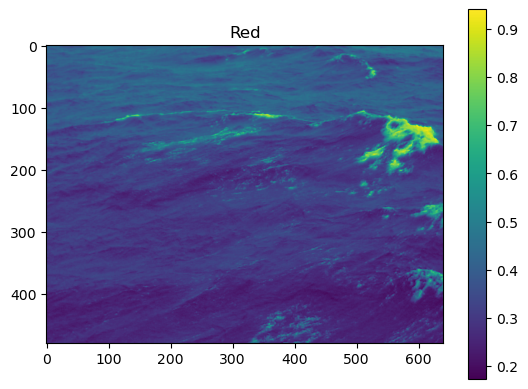

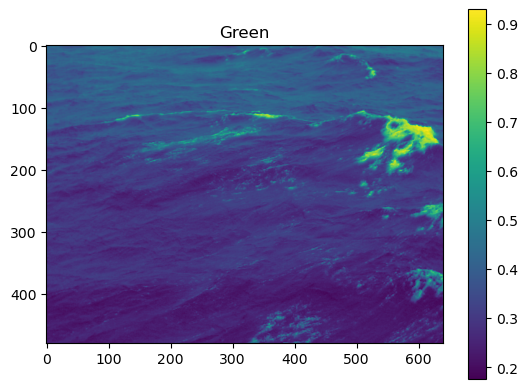

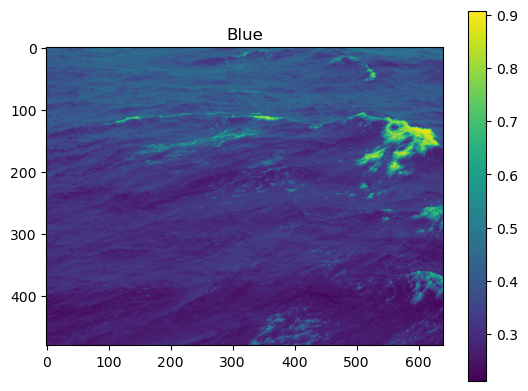

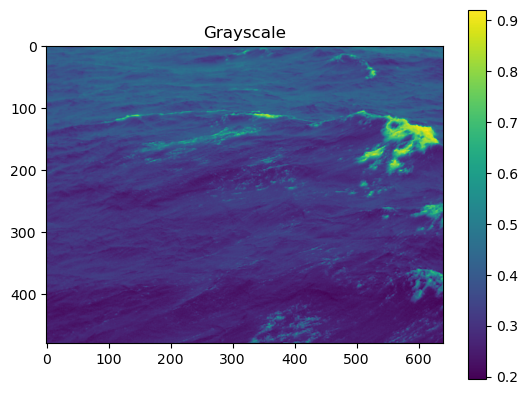

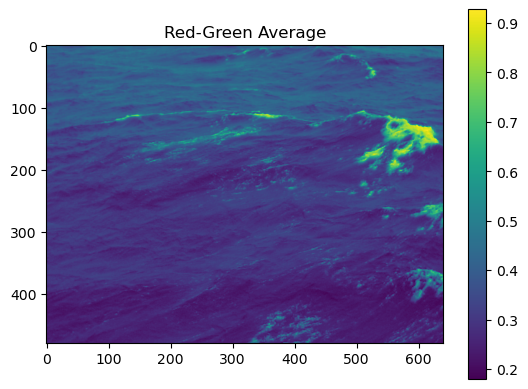

In [32]:
plt.figure(1); plt.imshow(im[:,:,0]); plt.title('Red'); plt.colorbar()
plt.figure(2); plt.imshow(im[:,:,1]); plt.title('Green'); plt.colorbar()
plt.figure(3); plt.imshow(im[:,:,2]); plt.title('Blue'); plt.colorbar()
plt.figure(4); plt.imshow(np.mean(im, axis=2)); plt.title('Grayscale'); plt.colorbar()
plt.figure(5); plt.imshow(im_rg); plt.title('Red-Green Average'); plt.colorbar()


In [33]:
nr, _ = im_rg.shape #nr is number of rows in cropped image 

#not really understand what is going on in here, ask adrian 

# Define the vertices of the region to blank
BW = np.zeros(im_rg.shape, dtype=bool) #creates array of  values the same size of the image 
                                             # bianry image with all false values, 'black?)
 
BW[polygon(
    [nr, 500, nr, nr], #500 is rows of polygon vertices 
    [2300, 4000, 4000, 2300], # x coordiantes for polygon vertices 
    shape=im_rg.shape #polygon coordinates  clipped to fit within the bounds of the image dimensions
)] = True #pixels inside the polygon are set to ture (white)
        # pixels outside are set as false (black) 
#The region is blanked out to prevent it from interfering with whitecap detection


In [23]:
BW.sum()


np.int64(0)

In [34]:
blank_indices = np.where(BW)


In [35]:
blank_indices

(array([], dtype=int64), array([], dtype=int64))

In [36]:
im_processed = im_rg.copy()
im_processed[blank_indices] = 2

In [ ]:
im_rg == im_processed


In [37]:
background = minimum_filter(im_processed, size=150)


In [38]:
im_processed[blank_indices] = np.nan
background[blank_indices] = np.nan


In [39]:
background_smoothed = filters.gaussian(background, sigma=30)

# Subtract background
im_subtracted = im_processed - background_smoothed

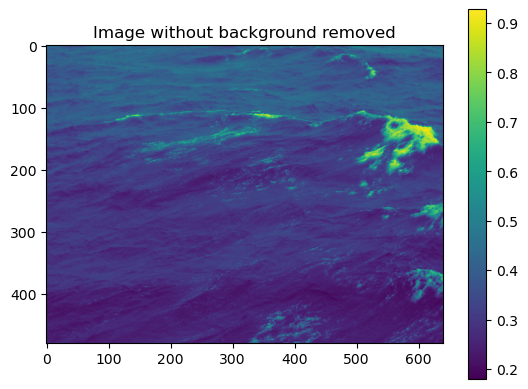

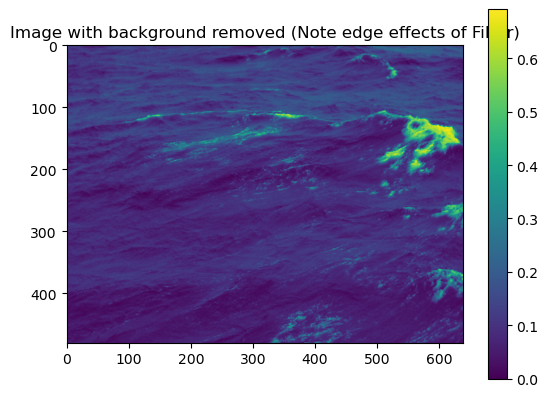

In [40]:
plt.figure(1)
plt.clf()
plt.title('Image without background removed')
plt.imshow(im_rg)
plt.colorbar()

plt.figure(2)
plt.clf()
plt.title('Image with background removed (Note edge effects of Filter)')
plt.imshow(im_subtracted)
plt.colorbar()

np.float64(0.6925830429295916)

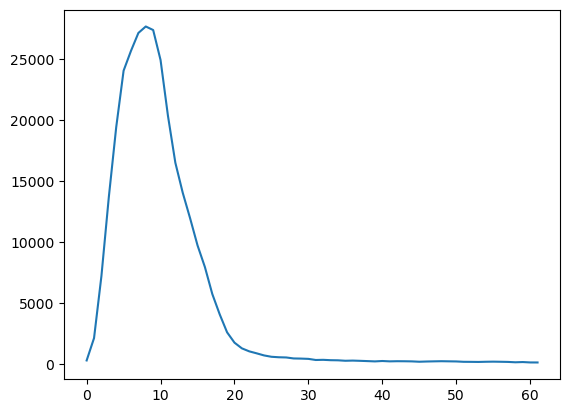

In [49]:
plt.plot(hist)
plt.show()

In [43]:
intensity_vector = np.arange(0, np.nanmax(im_subtracted)*0.9, 0.01)
'''
np.nanmax(im_crop_subtracted): Finds the maximum intensity value in the image, ignoring NaN values.
*0.9: Multiplies by 0.9 to avoid extreme outliers at the maximum intensity.
np.arange(start, stop, step): Creates a range of intensity thresholds from 0 to 90% of the max intensity with a step size of 0.01. 
'''

# Calculate the PIP
hist, bin_edges = np.histogram(im_subtracted[~np.isnan(im_subtracted)], 
                                bins=intensity_vector)

'''
Counts how many pixel intensities fall within each range (bin) defined by the intensty vector
    Excludes NaN values to ensure valid calculations.
np.histogram: Computes the histogram, returning:
hist: Counts of pixels in each bin.
bin_edges: The boundaries of the bins.
'''

# Flip to start at highest intensity threshold to lowest
hist_reversed = hist[::-1]
bin_edges_reversed = bin_edges[::-1]

# Get cumulative sum at each successively lower intensity
cumulative_sum = np.cumsum(hist_reversed)



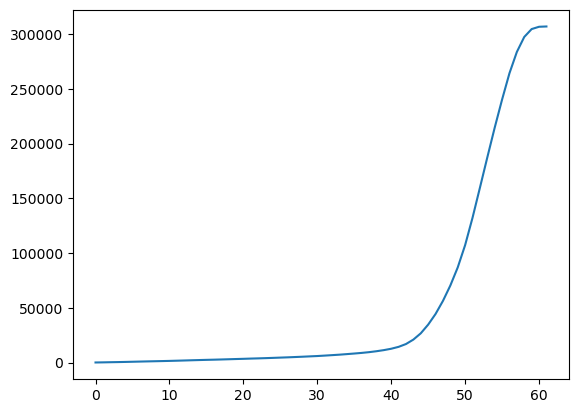

In [54]:
plt.plot(cumulative_sum)
plt.show()

In [55]:
cumulative_sum

array([   100,    203,    338,    454,    600,    758,    926,   1085,
         1229,   1380,   1535,   1720,   1914,   2118,   2311,   2491,
         2652,   2842,   3042,   3246,   3438,   3659,   3848,   4061,
         4296,   4551,   4792,   5070,   5358,   5676,   5980,   6376,
         6795,   7226,   7738,   8267,   8835,   9514,  10365,  11378,
        12638,  14366,  16942,  20997,  26718,  34652,  44371,  56307,
        70345,  86851, 107210, 132147, 159550, 187245, 214408, 240104,
       264170, 283591, 297271, 304470, 306570, 306836])

In [56]:
np.gradient(cumulative_sum)

array([  103. ,   119. ,   125.5,   131. ,   152. ,   163. ,   163.5,
         151.5,   147.5,   153. ,   170. ,   189.5,   199. ,   198.5,
         186.5,   170.5,   175.5,   195. ,   202. ,   198. ,   206.5,
         205. ,   201. ,   224. ,   245. ,   248. ,   259.5,   283. ,
         303. ,   311. ,   350. ,   407.5,   425. ,   471.5,   520.5,
         548.5,   623.5,   765. ,   932. ,  1136.5,  1494. ,  2152. ,
        3315.5,  4888. ,  6827.5,  8826.5, 10827.5, 12987. , 15272. ,
       18432.5, 22648. , 26170. , 27549. , 27429. , 26429.5, 24881. ,
       21743.5, 16550.5, 10439.5,  4649.5,  1183. ,   266. ])

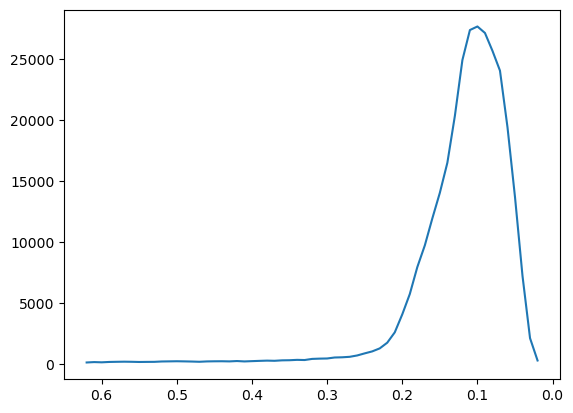

In [80]:
plt.plot(bin_edges_reversed[:-2], np.diff(cumulative_sum))
plt.gca().invert_xaxis()

In [81]:
  # Small constant to prevent division by zero

pip = np.diff(cumulative_sum)/(cumulative_sum [1:]) #likely something wrong with this line



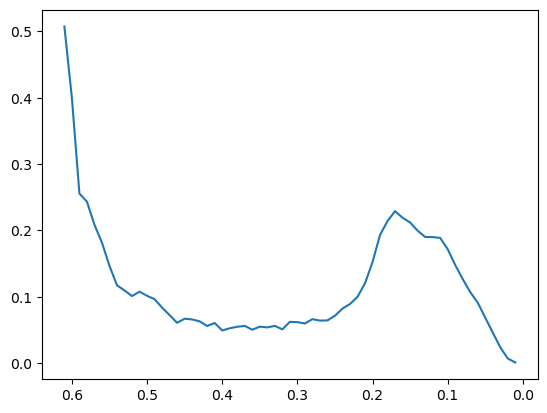

In [84]:

plt.plot(bin_edges_reversed[1:-1], pip)
plt.gca().invert_xaxis()

In [66]:
pip_smoothed =filters.gaussian(pip[1:], sigma=5)


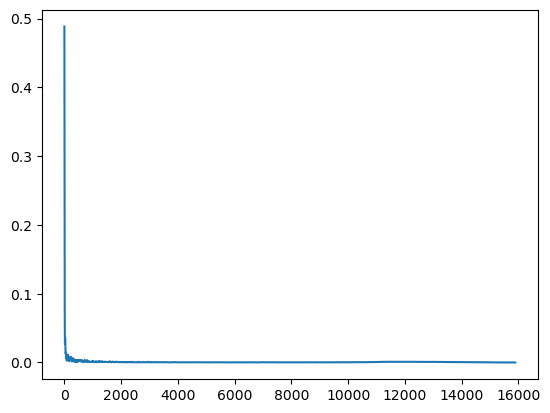

In [68]:
plt.plot(pip_smoothed)

In [18]:
#pip_smoothed = filters.gaussian_filter1d(pip, sigma=5)

# Calculate first and second derivatives
grad_pip = np.gradient(pip[::-1]) #reversed bc reversed histogram



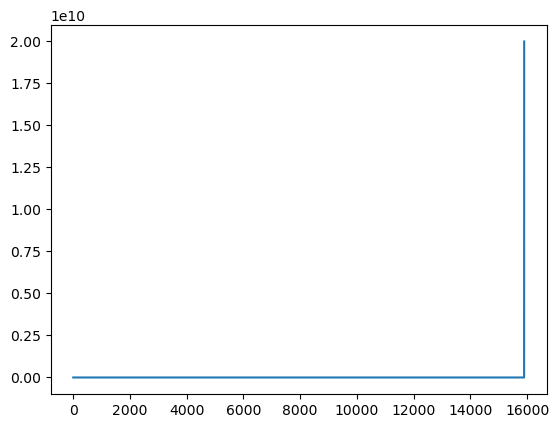

In [19]:
plt.plot(grad_pip)
plt.show()

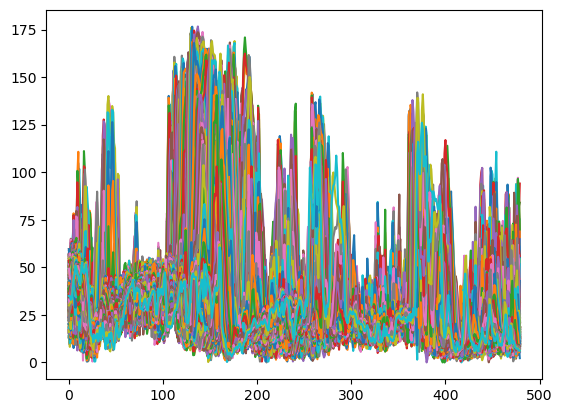

In [47]:
plt.plot(im_subtracted)
plt.show()

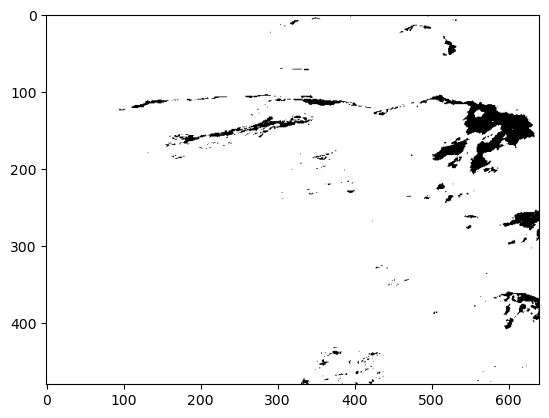

In [93]:
# Display image structu



# Binary threshold for whitecaps
whitecap_mask = im_subtracted >0.25
plt.figure(5)
plt.imshow(whitecap_mask, cmap='binary')

